In [1]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

In [42]:
trajectory='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/Trajectories/Replica_fromXTC_0.xtc'
pdb='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/Trajectories/prot.drug.pdb'
outdir='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/demo'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/demo
pdb: /Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/Trajectories/prot.drug.pdb
trjaectory: /Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/Trajectories/Replica_fromXTC_0.xtc


In [3]:
trj = md.load(trajectory, top=pdb,stride=100)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)



** SYSTEM INFO **

Number of atoms: 739

Number of residues: 58

Number of frames: 572

Starting frame: 0

Last frame: 572

sequence:  [ACE0, LEU1, ASP2, TYR3, GLY4, SER5, ALA6, TRP7, ALA8, ALA9, ALA10, ALA11, ALA12, GLN13, CYS14, ARG15, TYR16, GLY17, ASP18, LEU19, ALA20, SER21, LEU22, HIS23, GLY24, ALA25, GLY26, ALA27, ALA28, GLY29, PRO30, GLY31, SER32, GLY33, SER34, PRO35, SER36, ALA37, ALA38, ALA39, SER40, SER41, SER42, TRP43, HIS44, THR45, LEU46, PHE47, THR48, ALA49, GLU50, GLU51, GLY52, GLN53, LEU54, TYR55, GLY56, NH257]

residue names:  ['ACE', 'LEU', 'ASP', 'TYR', 'GLY', 'SER', 'ALA', 'TRP', 'ALA', 'ALA', 'ALA', 'ALA', 'ALA', 'GLN', 'CYS', 'ARG', 'TYR', 'GLY', 'ASP', 'LEU', 'ALA', 'SER', 'LEU', 'HIS', 'GLY', 'ALA', 'GLY', 'ALA', 'ALA', 'GLY', 'PRO', 'GLY', 'SER', 'GLY', 'SER', 'PRO', 'SER', 'ALA', 'ALA', 'ALA', 'SER', 'SER', 'SER', 'TRP', 'HIS', 'THR', 'LEU', 'PHE', 'THR', 'ALA', 'GLU', 'GLU', 'GLY', 'GLN', 'LEU', 'TYR', 'GLY', 'NH2']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8,

In [5]:
prot_sel='residue 1 to 56'
prot_top=top.subset(top.select(prot_sel))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
prot_residues=len(set(prot_res))

print(prot_residues)
print(prot_resname)
residue_offset=390 
prot_res_renum=np.asarray(prot_res)+residue_offset
print(prot_res_renum)

56
 ['LEU', 'ASP', 'TYR', 'GLY', 'SER', 'ALA', 'TRP', 'ALA', 'ALA', 'ALA', 'ALA', 'ALA', 'GLN', 'CYS', 'ARG', 'TYR', 'GLY', 'ASP', 'LEU', 'ALA', 'SER', 'LEU', 'HIS', 'GLY', 'ALA', 'GLY', 'ALA', 'ALA', 'GLY', 'PRO', 'GLY', 'SER', 'GLY', 'SER', 'PRO', 'SER', 'ALA', 'ALA', 'ALA', 'SER', 'SER', 'SER', 'TRP', 'HIS', 'THR', 'LEU', 'PHE', 'THR', 'ALA', 'GLU', 'GLU', 'GLY', 'GLN', 'LEU', 'TYR', 'GLY']
[391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446]


In [10]:
trj_prot = md.load(trajectory, top=pdb,stride=100)
prot_top=top.select(prot_sel)
trj_prot.restrict_atoms(prot_top)
trj_prot.center_coordinates()

frames=trj.n_frames
half=int(np.floor(frames/2))
print(frames,half)
dssp=md.compute_dssp(trj_prot,simplified=True)
dssp

572 286


array([['C', 'C', 'C', ..., 'C', 'C', 'C'],
       ['C', 'C', 'C', ..., 'C', 'C', 'C'],
       ['C', 'C', 'C', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'C', 'C', ..., 'E', 'C', 'C'],
       ['C', 'C', 'C', ..., 'E', 'C', 'C'],
       ['C', 'C', 'C', ..., 'H', 'C', 'C']], dtype='<U2')

In [26]:
#Number of Rowds
print(dssp.shape)
print("Rows:",len(dssp))
print("Columns:",len(dssp[0]))
#Print first Row

#Print out helix and beta residues for a given frame
frame=50
dssp_frame=np.column_stack((prot_res,dssp[frame]))
helix_res=np.where(a[:,1]=='H')
beta_res=np.where(a[:,1]=='E')
print('helical residues:',dssp_frame[helix_res])
print('beta residues:',dssp_frame[beta_res])

(572, 56)
Rows: 572
Columns: 56
helical residues: [['2' 'H']
 ['3' 'H']
 ['4' 'H']
 ['5' 'H']
 ['6' 'H']
 ['7' 'H']
 ['8' 'H']
 ['9' 'H']
 ['41' 'H']
 ['42' 'H']
 ['43' 'H']
 ['44' 'H']
 ['45' 'H']
 ['46' 'H']]
beta residues: [['12' 'E']
 ['15' 'E']
 ['33' 'E']
 ['39' 'E']]


In [38]:
#Find all the frames where a given residue is H or E
residue_number=7
array_index=residue_number-1
helix_frames=np.where(dssp[:,array_index]=='H')
beta_frames=np.where(dssp[:,array_index]=='E')

print("helix_frames:",helix_frames)
print("helix_frames:",beta_frames)

helix_frames: (array([  1,   2,   3,   4,  10,  13,  14,  16,  17,  18,  21,  22,  23,
        24,  25,  26,  28,  29,  32,  33,  36,  37,  38,  40,  41,  44,
        46,  48,  49,  50,  52,  55,  56,  57,  58,  60,  62,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  87,  90,  91,  92,  93,  94,  95,  96,
        97, 102, 103, 105, 107, 110, 111, 112, 113, 115, 116, 118, 119,
       120, 123, 124, 125, 127, 128, 129, 132, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 144, 147, 148, 150, 151, 153, 154, 156, 157,
       159, 165, 167, 168, 170, 171, 175, 176, 177, 183, 184, 186, 187,
       188, 190, 191, 193, 194, 195, 197, 199, 200, 201, 202, 203, 204,
       205, 207, 208, 209, 210, 211, 213, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 238, 239, 240, 241, 242, 245, 249, 250, 251, 254, 255,
       256, 257, 259, 260, 262, 263, 265, 266, 26

In [43]:
#Save a subset of the trajectory corresponding to some assignment
newtraj = trj[helix_frames]
name='TYR7_H'
print('%s/frames_with_%s.dcd' % (outdir,name))
md.Trajectory.save_dcd(newtraj, '%s/frames_with_%s.dcd' % (outdir,name))
print(newtraj)

/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/demo/frames_with_TYR7_H.dcd
<mdtraj.Trajectory with 394 frames, 739 atoms, 58 residues, and unitcells>


In [47]:
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 SE_H=np.zeros((len(dssp[0]),2))
 for i in range(0,len(dssp[0])): 
     data=dsspH[:,i].astype(float) 
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5] 
 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 SE_E=np.zeros((len(dssp[0]),2))
 for i in range(0,len(dssp[0])):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
 return SE_H, SE_E

#Calculate Secondary Structure Propensity
frames=trj.n_frames
half=int(np.floor(frames/2))

dssp=md.compute_dssp(trj_prot, simplified=True)
dssp_h2=md.compute_dssp(trj_prot[half:-1], simplified=True)
dssp_h1=md.compute_dssp(trj_prot[0:half], simplified=True)

Hprop,Eprop=dssp_convert(dssp)
H_h2,E_h2=dssp_convert(dssp_h2)
H_h1,E_h1=dssp_convert(dssp_h1)

<ipython-input-47-b953b514b7e6>:24: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


In [55]:
#Save the Helix and Betasheet Propensities
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.savetxt('%s/Hprop.resid.dat'%outdir,np.column_stack((prot_res,Hprop)),fmt='%.3f')
np.savetxt('%s/Hprop.resid.dat'%outdir,np.column_stack((prot_res,Eprop)),fmt='%.3f')

#renumber the residues with our offset and save those propensities
np.savetxt('%s/Hprop.resid.dat'%outdir,np.column_stack((prot_res_renum,Hprop)),fmt='%.3f')
np.savetxt('%s/Hprop.resid.dat'%outdir,np.column_stack((prot_res_renum,Eprop)),fmt='%.3f')


#print(np.column_stack((prot_res_renum,Hprop)))
#print(np.column_stack((prot_res,Hprop)))

/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/demo/Hprop.resid.dat


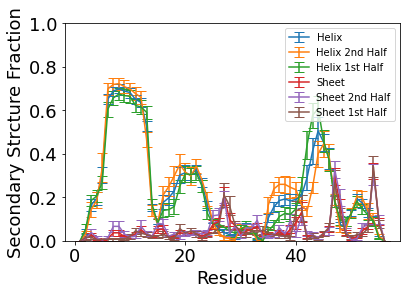

In [59]:
#plt.errorbar(x_values,y_values,error_bars)
plt.errorbar(prot_res,Hprop[:,0],yerr=Hprop[:,1], capsize=5,label='Helix')
plt.errorbar(prot_res,H_h2[:,0],yerr=H_h2[:,1], capsize=5,label='Helix 2nd Half')
plt.errorbar(prot_res,H_h1[:,0],yerr=H_h1[:,1], capsize=5,label='Helix 1st Half')
plt.errorbar(prot_res,Eprop[:,0],yerr=Eprop[:,1], capsize=5,label='Sheet')
plt.errorbar(prot_res,E_h1[:,0],yerr=E_h1[:,1], capsize=5,label='Sheet 2nd Half')
plt.errorbar(prot_res,E_h2[:,0],yerr=E_h2[:,1], capsize=5,label='Sheet 1st Half')

plt.ylim(0,1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
plt.savefig('%s/Hprop.pdf'%outdir)

sequence:  [ACE0, LEU1, ASP2, TYR3, GLY4, SER5, ALA6, TRP7, ALA8, ALA9, ALA10, ALA11, ALA12, GLN13, CYS14, ARG15, TYR16, GLY17, ASP18, LEU19, ALA20, SER21, LEU22, HIS23, GLY24, ALA25, GLY26, ALA27, ALA28, GLY29, PRO30, GLY31, SER32, GLY33, SER34, PRO35, SER36, ALA37, ALA38, ALA39, SER40, SER41, SER42, TRP43, HIS44, THR45, LEU46, PHE47, THR48, ALA49, GLU50, GLU51, GLY52, GLN53, LEU54, TYR55, GLY56, NH257]

In [70]:
trp7=trj_prot.topology.select('resid 7 and not type H')
for i in trp7:
    print(trj_prot.topology.atom(i))

trp43=trj_prot.topology.select('resid 43 and not type H')
for i in trp43:
    print(trj_prot.topology.atom(i))

TRP7-N
TRP7-CA
TRP7-CB
TRP7-CG
TRP7-CD1
TRP7-NE1
TRP7-CE2
TRP7-CZ2
TRP7-CH2
TRP7-CZ3
TRP7-CE3
TRP7-CD2
TRP7-C
TRP7-O
TRP43-N
TRP43-CA
TRP43-CB
TRP43-CG
TRP43-CD1
TRP43-NE1
TRP43-CE2
TRP43-CZ2
TRP43-CH2
TRP43-CZ3
TRP43-CE3
TRP43-CD2
TRP43-C
TRP43-O


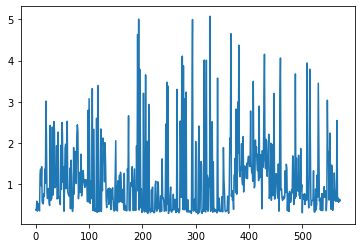

In [80]:
#Compute Distance Between 2 residues
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_contacts.html
dist = md.compute_contacts(trj,[[7,43]])
dist_array = np.asarray(dist[0]).astype(float)
plt.plot(dist_array)
np.savetxt('%s/Trp7.Trp43.dist.dat'%outdir,dist_array,fmt='%.3f')


[169.000 113.000 71.000 47.000 42.000 27.000 18.000 18.000 14.000 11.000
 4.000 9.000 7.000 4.000 5.000 6.000 1.000 1.000 2.000 3.000] [0.283 0.523 0.762 1.002 1.242 1.481 1.721 1.961 2.201 2.440 2.680 2.920
 3.159 3.399 3.639 3.878 4.118 4.358 4.598 4.837 5.077]


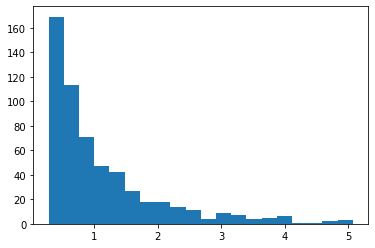

In [91]:
#Plot a histogram
counts,xedges,patches=plt.hist(dist_array,bins=20)
print(dist_hist,xedges)

In [98]:
#dist = md.compute_contacts(traj,[[i,58]])
#array = np.asarray(dist[0]).astype(float)
contact = np.where(dist_array < 0.5, 1, 0)
newframes = []
for i in range(len(trj_prot)):
 if contact[i]==1:
    newframes.append(i)
frames = np.asarray(newframes)
newtraj = trj_prot[frames]
md.Trajectory.save_dcd(newtraj, '%s/Trp7Trp43_lt_0.5nm.dcd' % outdir)
print(newtraj)

<mdtraj.Trajectory with 164 frames, 730 atoms, 56 residues, and unitcells>


In [99]:
def calc_SA(trj,helix,start,stop):
 RMS_start=start
 RMS_stop=stop
 RMS=[]
 for i in range(RMS_start,RMS_stop):
    sel=helix.topology.select("residue %s to %s and name CA" % (i,i+6))
    rmsd = md.rmsd(trj,helix,atom_indices=sel)
    RMS.append(rmsd)
 RMS=np.asarray(RMS)
 Sa_sum=np.zeros((trj.n_frames))
 Sa=(1.0-(RMS/0.08)**8)/(1-(RMS/0.08)**12)
 return Sa

def calc_Rg(trj):
 mass=[]
 for at in trj.topology.atoms:
    mass.append(at.element.mass)
 mass_CA = len(mass)*[0.0]
 for i in trj.topology.select("name CA"): mass_CA[i]=1.0
 rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
 return rg_CA

def free_energy(a,b,T,y0,ymax,x0,xmax):
  free_energy,xedges,yedges=np.histogram2d(a,b,30,[[y0,ymax],[x0,xmax]],normed=True,weights=None)
  free_energy=np.log(np.flipud(free_energy)+.000001)
  free_energy=-(0.001987*T)*free_energy
  return free_energy,xedges,yedges

def free_energy_1D(a,T,x0,xmax,bins):
  free_energy,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=None)
  max=np.max(free_energy)  
  free_energy=np.log(free_energy+.0000001)
  free_energy=-(0.001987*T)*(free_energy-np.log(max+.0000001))
  xcenters= xedges[:-1] + np.diff(xedges)/2
  return free_energy,xcenters

CA Radius of Gyration: 1.259 +_ 0.015


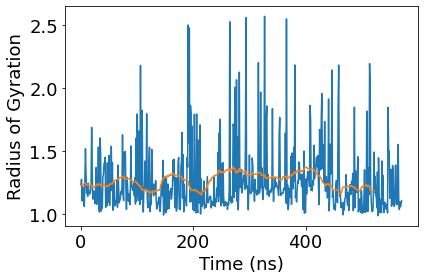

In [102]:
def calc_Rg(trj):
 mass=[]
 for at in trj.topology.atoms:
    mass.append(at.element.mass)
 mass_CA = len(mass)*[0.0]
 for i in trj.topology.select("name CA"): mass_CA[i]=1.0
 rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
 return rg_CA

rg_CA=calc_Rg(trj_prot)
N=50
plt.clf()
plt.plot(rg_CA)
plt.plot(np.convolve(rg_CA,np.ones(N)/N,mode='valid'))
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
print("CA Radius of Gyration:%6.3lf"%np.average(rg_CA),"+_%6.3lf"%block(rg_CA)**.5)
plt.savefig(outdir+'rg.png')
np.savetxt(outdir+'rg.dat',rg_CA)

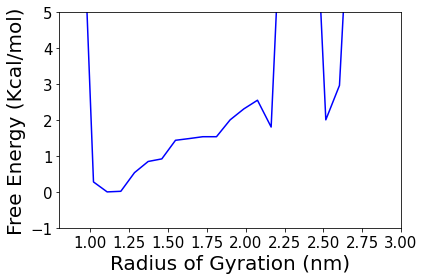

In [107]:
rg_lower=0.8
rg_upper=3.0

Rg_dG, edges = free_energy_1D(rg_CA, 300, rg_lower,rg_upper, 25)
plt.clf()
plt.plot(edges, Rg_dG,c='blue')

plt.ylim(-1, 5)
plt.xlim(rg_lower,rg_upper)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
#plt.legend(loc='upper right', fontsize=14)

np.savetxt(outdir+'rg.dG.dat',np.column_stack((edges, Rg_dG)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.png'%outdir)
plt.show()

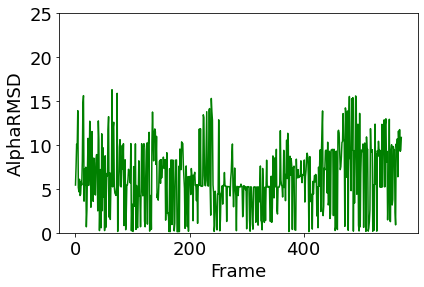

In [110]:
helixpdb='/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2R3_all_helix.pdb'
helixBB = md.load_pdb(helixpdb)
trjBB = md.load(trajectory, top=pdb,stride=100)
BB=trjBB.topology.select("name CA")
HBB = helixBB.topology.select("name CA")

trjBB.restrict_atoms(BB)
helixBB.restrict_atoms(HBB)
trjBB.center_coordinates()
helixBB.center_coordinates()

Sa=calc_SA(trjBB,helixBB,0, 51)
Sa_total=np.sum(Sa, axis=0)
Sa_ave=np.average(Sa,axis=1)

plt.plot(Sa_total,label='Full',c='g')
plt.xlabel('Frame', size=18)
plt.ylabel('AlphaRMSD', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0,25)
plt.savefig(outdir+'Sa.timecourse.png')
np.savetxt(outdir+'Sa_total.dat',Sa_total)


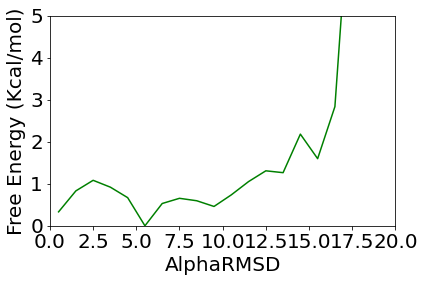

In [112]:
Sa_dg, edges = free_energy_1D(Sa_total, 300, 0, 25, 25)
plt.plot(edges, Sa_dg, c='g',label='Total')
plt.ylim(0, 5)
plt.xlim(0, 20)
plt.xlabel('AlphaRMSD', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
plt.savefig(outdir+'Sa.dG.png')


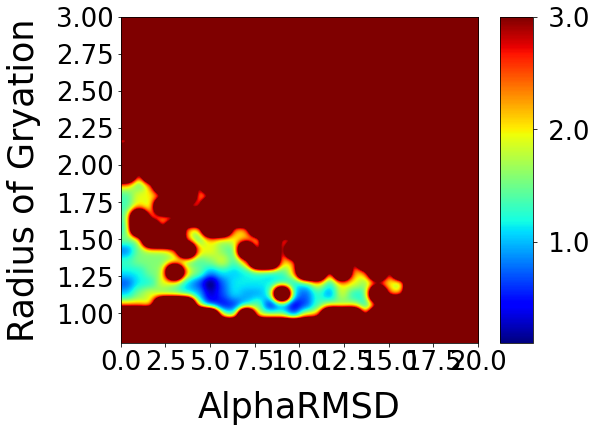

In [113]:
Sa_lower=0
Sa_upper=20

dG,xedges,yedges=free_energy(rg_CA,Sa_total,300,rg_lower,rg_upper,Sa_lower,Sa_upper)

fig=plt.figure(figsize=(8,6))
im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
cbar_ticks=[0,1,2,3,4,5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Radius of Gryation",size=35,labelpad=15)
plt.xlabel("AlphaRMSD",size=35,labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='26')
plt.axes(cb.ax)
plt.clim(vmin=0.1,vmax=3.0)
plt.yticks(size='26')

np.savetxt(outdir+'Rg_v_Sa.dat',dG)
plt.savefig(outdir+'Rg_v_Sa.png')

In [122]:
rg_CA,Sa_total
rg1=np.where(rg_CA>1.0)
rg2=np.where(rg_CA<1.3)
rg_bounded=np.intersect1d(rg1,rg2)
sa1=np.where(Sa_total>5.0)
sa2=np.where(Sa_total<7.5)
sa_bounded=np.intersect1d(sa1,sa2)
bounded=np.intersect1d(rg_bounded,sa_bounded)
newtraj = trj[bounded]
name='Sa_5_7.5.Rg_1_1.3'
print('%s/frames_with_%s.dcd' % (outdir,name))
md.Trajectory.save_dcd(newtraj, '%s/frames_with_%s.dcd' % (outdir,name))
print(newtraj)

/Users/paulrobustelli/Desktop/Trajectories/AR_3.18.2021/R2_R3_APO/demo/frames_with_Sa_5_7.5.Rg_1_1.3.dcd
<mdtraj.Trajectory with 156 frames, 739 atoms, 58 residues, and unitcells>
